In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
import librosa
import librosa.display
import ctc_chroma

In [4]:
# Create DataFrame from Waveplot
# File too big for GitHub
# wave = pd.read_csv('20210818_165154_Wave.csv', delimiter=';')

In [5]:
# We seperated the long recording into different sections where different pieces were recorded
# Create separate DataFrames for the different recordings
wave1 = pd.read_csv('20210818_165154_Wave1.csv', delimiter=';')
wave2 = pd.read_csv('20210818_165154_Wave2.csv', delimiter=';')
# File too big for GitHub
# wave3 = pd.read_csv('20210818_165154_Wave3.csv', delimiter=';')
wave4 = pd.read_csv('20210818_165154_Wave4.csv', delimiter=';')
wave5 = pd.read_csv('20210818_165154_Wave5.csv', delimiter=';')
wave6 = pd.read_csv('20210818_165154_Wave6.csv', delimiter=';')
wave7 = pd.read_csv('20210818_165154_Wave7.csv', delimiter=';')

In [6]:
# Get our IMU data
acc = pd.read_csv('20210818_165154_AccR.csv', delimiter=';')
gy = pd.read_csv('20210818_165154_GyR.csv', delimiter=';')

In [7]:
# we have commas instead of dots so we can't convert the string entries to float
acc['Acc gesamt'] = acc['Acc gesamt'].str.replace(',','.', regex=True)
gy['Gy gesamt'] = gy['Gy gesamt'].str.replace(',','.', regex=True)

# convert our data to float
acc = acc.astype(float)
gy = gy.astype(float)

# merge the to dataframes together
imu = pd.concat([acc, gy], axis=1)

In [8]:
# Create the corresponding DataFrames with the IMU data for the recordings
imu1 = imu.iloc[189:2727]
imu2 = imu.iloc[2650:5155]
imu3 = imu.iloc[5080:8910]
imu4 = imu.iloc[8837:11309]
imu5 = imu.iloc[11217:12942]
imu6 = imu.iloc[12862:14853]
imu7 = imu.iloc[14752:16822]

In [9]:
# We use the ctc_chroma model from # https://github.com/fzalkow/ctc_chroma/blob/master/ctc_chroma/features.py
# to generate chromagrams for the wave files
cur_model_id = 'v2_ctc_train512valid3'
# File too big for GitHub
# cur_audio_path = '20210818_165154.wav'

model = ctc_chroma.models.get_model(cur_model_id)

In [10]:
# since we already cut down our data we copy the functions from GitHub

def get_hcqt_params():
    """Hack to always use the same parameters :)
    Function from https://github.com/rabitt/ismir2017-deepsalience"""
    bins_per_octave = 36
    n_octaves = 6
    harmonics = [0.5, 1, 2, 3, 4, 5]
    sr = 22050
    fmin = 32.7
    hop_length = 256
    return bins_per_octave, n_octaves, harmonics, sr, fmin, hop_length


def compute_hcqt(y, fs):
    """Compute the harmonic CQT from a given audio file
    Function from https://github.com/rabitt/ismir2017-deepsalience"""
    (bins_per_octave, n_octaves, harmonics,
     sr, f_min, hop_length) = get_hcqt_params()
    # y, fs = librosa.load(audio_fpath, sr=sr)

    cqt_list = []
    shapes = []
    for h in harmonics:
        cqt = librosa.cqt(y, sr=fs, hop_length=hop_length, fmin=f_min*float(h), n_bins=bins_per_octave*n_octaves,
                          bins_per_octave=bins_per_octave)
        cqt_list.append(cqt)
        shapes.append(cqt.shape)

    shapes_equal = [s == shapes[0] for s in shapes]
    if not all(shapes_equal):
        min_time = np.min([s[1] for s in shapes])
        new_cqt_list = []
        for i in range(len(cqt_list)):
            new_cqt_list.append(cqt_list[i][:, :min_time])
        cqt_list = new_cqt_list

    log_hcqt = ((1.0 / 80.0) * librosa.core.amplitude_to_db(np.abs(np.array(cqt_list)), ref=np.max)) + 1.0

    return log_hcqt


def compute_hcqt_median(y, fs, feature_rate):
    hcqt = compute_hcqt(y, fs)
    times = get_time_grid(len(hcqt[0][0]))
    freqs = get_freq_grid()

    # interpolate times
    eps = np.finfo(float).eps
    new_times = np.arange(times[0], times[-1] + eps, 1.0/feature_rate)  # add eps to include last time point

    return median_bin_salience(hcqt, times, new_times, axis=-1), new_times, freqs


def median_bin_salience(salience, old_times, new_times, axis=1):

    idx = []
    for i in range(len(new_times)):
        start_time = new_times[i]
        idx.append(np.searchsorted(old_times, start_time))
    idx.append(len(old_times))

    new_X = librosa.util.sync(salience, idx, aggregate=np.median, pad=False, axis=axis)

    return new_X


def get_time_grid(n_time_frames):
    """Get the hcqt time grid
    Function from https://github.com/rabitt/ismir2017-deepsalience"""
    (_, _, _, sr, _, hop_length) = get_hcqt_params()
    time_grid = librosa.core.frames_to_time(range(n_time_frames), sr=sr, hop_length=hop_length)
    return time_grid


def get_freq_grid():
    """Get the hcqt frequency grid
    Function from https://github.com/rabitt/ismir2017-deepsalience"""
    (bins_per_octave, n_octaves, _, _, f_min, _) = get_hcqt_params()
    freq_grid = librosa.cqt_frequencies(bins_per_octave*n_octaves, f_min, bins_per_octave=bins_per_octave)
    return freq_grid

In [11]:
lib_x1 = wave1.to_numpy()
lib_x2 = wave2.to_numpy()
# lib_x3 = wave3.to_numpy()
lib_x4 = wave4.to_numpy()
lib_x5 = wave5.to_numpy()
lib_x6 = wave6.to_numpy()
lib_x7 = wave7.to_numpy()

lib_x1 = lib_x1.flatten()
lib_x2 = lib_x2.flatten()
# lib_x3 = lib_x3.flatten()
lib_x4 = lib_x4.flatten()
lib_x5 = lib_x5.flatten()
lib_x6 = lib_x6.flatten()
lib_x7 = lib_x7.flatten()

In [12]:
hcqt1, times1, freqs1 = compute_hcqt_median(lib_x1, 22050, feature_rate=25)
hcqt2, times2, freqs2 = compute_hcqt_median(lib_x2, 22050, feature_rate=25)
# hcqt3, times3, freqs3 = compute_hcqt_median(lib_x3, 22050, feature_rate=25)
hcqt4, times4, freqs4 = compute_hcqt_median(lib_x4, 22050, feature_rate=25)
hcqt5, times5, freqs5 = compute_hcqt_median(lib_x5, 22050, feature_rate=25)
hcqt6, times6, freqs6 = compute_hcqt_median(lib_x6, 22050, feature_rate=25)
hcqt7, times7, freqs7 = compute_hcqt_median(lib_x7, 22050, feature_rate=25)

In [13]:
hcqt_norm1 = librosa.util.normalize(hcqt1.T, norm=2, fill=True, axis=1)
hcqt_norm2 = librosa.util.normalize(hcqt2.T, norm=2, fill=True, axis=1)
# hcqt_norm3 = librosa.util.normalize(hcqt3.T, norm=2, fill=True, axis=1)
hcqt_norm4 = librosa.util.normalize(hcqt4.T, norm=2, fill=True, axis=1)
hcqt_norm5 = librosa.util.normalize(hcqt5.T, norm=2, fill=True, axis=1)
hcqt_norm6 = librosa.util.normalize(hcqt6.T, norm=2, fill=True, axis=1)
hcqt_norm7 = librosa.util.normalize(hcqt7.T, norm=2, fill=True, axis=1)

In [14]:
probabilities_ctc1 = model.predict(hcqt_norm1[np.newaxis, :, :, :])[0, :, :].T
probabilities_ctc2 = model.predict(hcqt_norm2[np.newaxis, :, :, :])[0, :, :].T
# probabilities_ctc3 = model.predict(hcqt_norm3[np.newaxis, :, :, :])[0, :, :].T
probabilities_ctc4 = model.predict(hcqt_norm4[np.newaxis, :, :, :])[0, :, :].T
probabilities_ctc5 = model.predict(hcqt_norm5[np.newaxis, :, :, :])[0, :, :].T
probabilities_ctc6 = model.predict(hcqt_norm6[np.newaxis, :, :, :])[0, :, :].T
probabilities_ctc7 = model.predict(hcqt_norm7[np.newaxis, :, :, :])[0, :, :].T

In [15]:
chroma_ctc1 = librosa.util.normalize(probabilities_ctc1[:-1, :], norm=2, fill=True, axis=0)
chroma_ctc2 = librosa.util.normalize(probabilities_ctc2[:-1, :], norm=2, fill=True, axis=0)
# chroma_ctc3 = librosa.util.normalize(probabilities_ctc3[:-1, :], norm=2, fill=True, axis=0)
chroma_ctc4 = librosa.util.normalize(probabilities_ctc4[:-1, :], norm=2, fill=True, axis=0)
chroma_ctc5 = librosa.util.normalize(probabilities_ctc5[:-1, :], norm=2, fill=True, axis=0)
chroma_ctc6 = librosa.util.normalize(probabilities_ctc6[:-1, :], norm=2, fill=True, axis=0)
chroma_ctc7 = librosa.util.normalize(probabilities_ctc7[:-1, :], norm=2, fill=True, axis=0)

In [16]:
bins_per_octave, n_octaves, harmonics, sr, fmin, hop_length = ctc_chroma.features.get_hcqt_params()


chroma_cqt1 = librosa.feature.chroma_cqt(C=hcqt_norm1[:, :, 1].T, fmin=fmin, bins_per_octave=bins_per_octave)
chroma_cqt2 = librosa.feature.chroma_cqt(C=hcqt_norm2[:, :, 1].T, fmin=fmin, bins_per_octave=bins_per_octave)
# chroma_cqt3 = librosa.feature.chroma_cqt(C=hcqt_norm3[:, :, 1].T, fmin=fmin, bins_per_octave=bins_per_octave)
chroma_cqt4 = librosa.feature.chroma_cqt(C=hcqt_norm4[:, :, 1].T, fmin=fmin, bins_per_octave=bins_per_octave)
chroma_cqt5 = librosa.feature.chroma_cqt(C=hcqt_norm5[:, :, 1].T, fmin=fmin, bins_per_octave=bins_per_octave)
chroma_cqt6 = librosa.feature.chroma_cqt(C=hcqt_norm6[:, :, 1].T, fmin=fmin, bins_per_octave=bins_per_octave)
chroma_cqt7 = librosa.feature.chroma_cqt(C=hcqt_norm7[:, :, 1].T, fmin=fmin, bins_per_octave=bins_per_octave)

In [17]:
# For some data cqt works better, for other ctc. 
# We take the chromagrams which give better results and transpose the arrays
chroma_cqt1_T = chroma_cqt1.transpose()
chroma_cqt2_T = chroma_cqt2.transpose()
# chroma_cqt3_T = chroma_cqt3.transpose()
chroma_ctc4_T = chroma_ctc4.transpose()
chroma_ctc5_T = chroma_ctc5.transpose()
chroma_ctc6_T = chroma_ctc6.transpose()
chroma_ctc7_T = chroma_ctc7.transpose()

In [18]:
# from ndarray to panda DataFrame
cqt1 = pd.DataFrame(data=chroma_cqt1_T, columns=['1','2','3','4','5','6','7','8','9','10','11','12'])
cqt2 = pd.DataFrame(data=chroma_cqt2_T, columns=['1','2','3','4','5','6','7','8','9','10','11','12'])
# cqt3 = pd.DataFrame(data=chroma_cqt3_T, columns=['1','2','3','4','5','6','7','8','9','10','11','12'])
ctc4 = pd.DataFrame(data=chroma_ctc4_T, columns=['1','2','3','4','5','6','7','8','9','10','11','12'])
ctc5 = pd.DataFrame(data=chroma_ctc5_T, columns=['1','2','3','4','5','6','7','8','9','10','11','12'])
ctc6 = pd.DataFrame(data=chroma_ctc6_T, columns=['1','2','3','4','5','6','7','8','9','10','11','12'])
ctc7 = pd.DataFrame(data=chroma_ctc7_T, columns=['1','2','3','4','5','6','7','8','9','10','11','12'])

In [19]:
# create a column for the most probable note
cqt1['Tones'] = cqt1.idxmax(1)
cqt2['Tones'] = cqt2.idxmax(1)
# cqt3['Tones'] = cqt3.idxmax(1)
ctc4['Tones'] = ctc4.idxmax(1)
ctc5['Tones'] = ctc5.idxmax(1)
ctc6['Tones'] = ctc6.idxmax(1)
ctc7['Tones'] = ctc7.idxmax(1)

In [20]:
# We want the first occurance of the note to mark our tone changes
cqt1['FirstOcc'] = cqt1['Tones'].shift() != cqt1['Tones']
cqt2['FirstOcc'] = cqt2['Tones'].shift() != cqt2['Tones']
# cqt3['FirstOcc'] = cqt3['Tones'].shift() != cqt3['Tones']
ctc4['FirstOcc'] = ctc4['Tones'].shift() != ctc4['Tones']
ctc5['FirstOcc'] = ctc5['Tones'].shift() != ctc5['Tones']
ctc6['FirstOcc'] = ctc6['Tones'].shift() != ctc6['Tones']
ctc7['FirstOcc'] = ctc7['Tones'].shift() != ctc7['Tones']

In [21]:
# change first occurence from boolean to int
cqt1['FirstOcc'] = cqt1['FirstOcc'].astype(int)
cqt2['FirstOcc'] = cqt2['FirstOcc'].astype(int)
# cqt3['FirstOcc'] = cqt3['FirstOcc'].astype(int)
ctc4['FirstOcc'] = ctc4['FirstOcc'].astype(int)
ctc5['FirstOcc'] = ctc5['FirstOcc'].astype(int)
ctc6['FirstOcc'] = ctc6['FirstOcc'].astype(int)
ctc7['FirstOcc'] = ctc7['FirstOcc'].astype(int)

In [22]:
# map the numbers to tone names
mapTone = {'1':'C', '2':'Cis', '3':'D', '4':'Dis', '5':'E', '6':'F', '7':'Fis', '8':'G', '9':'Gis', '10':'A', '11':'B', '12':'H'}
cqt1['TonesName'] = cqt1['Tones'].map(mapTone)
cqt2['TonesName'] = cqt2['Tones'].map(mapTone)
# cqt3['TonesName'] = cqt3['Tones'].map(mapTone)
ctc4['TonesName'] = ctc4['Tones'].map(mapTone)
ctc5['TonesName'] = ctc5['Tones'].map(mapTone)
ctc6['TonesName'] = ctc6['Tones'].map(mapTone)
ctc7['TonesName'] = ctc7['Tones'].map(mapTone)

In [23]:
# We cleaned the data manually and made the dataframes smaller to have only the relevant information
# the audio samples 4, 5 and 7 were a bit too messy so we just take 1-3 and 6
cqt1_cleaned = pd.read_csv('cqt1_cleaned.csv', sep=';', index_col=0)
cqt2_cleaned = pd.read_csv('cqt2_cleaned.csv', sep=';', index_col=0)
cqt3_cleaned = pd.read_csv('cqt3_cleaned.csv', sep=';', index_col=0)
ctc6_cleaned = pd.read_csv('ctc6_cleaned.csv', sep=';', index_col=0)

In [24]:
# To have equaly sized imu data and audio data we stretch our chromagram data and the interpolate 
# the imu data to fit the dataframe
# To have a stretched DataFrame we first produce an empty dataframe
index1 = range(3345)
index2 = range(3300)
index3 = range(5049)
index6 = range(2628)
columns = ['FirstOcc']

cqt1_stretched = pd.DataFrame(index=index1, columns=columns)
cqt2_stretched = pd.DataFrame(index=index2, columns=columns)
cqt3_stretched = pd.DataFrame(index=index3, columns=columns)
ctc6_stretched = pd.DataFrame(index=index6, columns=columns)

# get a subset of our stretched DataFrames the size of our data
cqt1_3 = cqt1_stretched.iloc[::3].copy()
cqt2_3 = cqt2_stretched.iloc[::3].copy()
cqt3_3 = cqt3_stretched.iloc[::3].copy()
ctc6_3 = ctc6_stretched.iloc[::3].copy()

# to overwrite the data we first need to reset the index
cqt1_3 = cqt1_3.reset_index()
cqt2_3 = cqt2_3.reset_index()
cqt3_3 = cqt3_3.reset_index()
ctc6_3 = ctc6_3.reset_index()

# Overwrite the data
cqt1_3['FirstOcc'] = cqt1_cleaned['FirstOcc']
cqt2_3['FirstOcc'] = cqt2_cleaned['FirstOcc']
cqt3_3['FirstOcc'] = cqt3_cleaned['FirstOcc']
ctc6_3['FirstOcc'] = ctc6_cleaned['FirstOcc']

# Reset the index to the original
cqt1_3 = cqt1_3.set_index('index')
cqt2_3 = cqt2_3.set_index('index')
cqt3_3 = cqt3_3.set_index('index')
ctc6_3 = ctc6_3.set_index('index')

# Overwrite the data in our stretched DataFrames
cqt1_stretched['FirstOcc'] = cqt1_3['FirstOcc']
cqt2_stretched['FirstOcc'] = cqt2_3['FirstOcc']
cqt3_stretched['FirstOcc'] = cqt3_3['FirstOcc']
ctc6_stretched['FirstOcc'] = ctc6_3['FirstOcc']

# replace NaN-values with 0
cqt1_stretched = cqt1_stretched.fillna(0)
cqt2_stretched = cqt2_stretched.fillna(0)
cqt3_stretched = cqt3_stretched.fillna(0)
ctc6_stretched = ctc6_stretched.fillna(0)

In [25]:
from scipy.interpolate import interp1d

In [26]:
# Interpolate our accelerometer and gyroscope data to have the same length with our tone data
x_acc1 = np.linspace(0, len(imu1)-1, num=len(imu1), endpoint=True)
y_acc1 = imu1['Acc gesamt']
f_acc1 = interp1d(x_acc1, y_acc1, kind='slinear')
xnew_acc1 = np.linspace(0, len(imu1)-1, num=len(cqt1_stretched))
ynew_acc1 = f_acc1(xnew_acc1) # use interpolation function returned by `interp1d`

x_gy1 = np.linspace(0, len(imu1)-1, num=len(imu1), endpoint=True)
y_gy1 = imu1['Gy gesamt']
f_gy1 = interp1d(x_gy1, y_gy1, kind='slinear')
xnew_gy1 = np.linspace(0, len(imu1)-1, num=len(cqt1_stretched))
ynew_gy1 = f_gy1(xnew_gy1) # use interpolation function returned by `interp1d`

x_acc2 = np.linspace(0, len(imu2)-1, num=len(imu2), endpoint=True)
y_acc2 = imu2['Acc gesamt']
f_acc2 = interp1d(x_acc2, y_acc2, kind='slinear')
xnew_acc2 = np.linspace(0, len(imu2)-1, num=len(cqt2_stretched))
ynew_acc2 = f_acc2(xnew_acc2) # use interpolation function returned by `interp1d`

x_gy2 = np.linspace(0, len(imu2)-1, num=len(imu2), endpoint=True)
y_gy2 = imu2['Gy gesamt']
f_gy2 = interp1d(x_gy2, y_gy2, kind='slinear')
xnew_gy2 = np.linspace(0, len(imu2)-1, num=len(cqt2_stretched))
ynew_gy2 = f_gy2(xnew_gy2) # use interpolation function returned by `interp1d`

x_acc3 = np.linspace(0, len(imu3)-1, num=len(imu3), endpoint=True)
y_acc3 = imu3['Acc gesamt']
f_acc3 = interp1d(x_acc3, y_acc3, kind='slinear')
xnew_acc3 = np.linspace(0, len(imu3)-1, num=len(cqt3_stretched))
ynew_acc3 = f_acc3(xnew_acc3) # use interpolation function returned by `interp1d`

x_gy3 = np.linspace(0, len(imu3)-1, num=len(imu3), endpoint=True)
y_gy3 = imu3['Gy gesamt']
f_gy3 = interp1d(x_gy3, y_gy3, kind='slinear')
xnew_gy3 = np.linspace(0, len(imu3)-1, num=len(cqt3_stretched))
ynew_gy3 = f_gy3(xnew_gy3) # use interpolation function returned by `interp1d`

x_acc6 = np.linspace(0, len(imu6)-1, num=len(imu6), endpoint=True)
y_acc6 = imu6['Acc gesamt']
f_acc6 = interp1d(x_acc6, y_acc6, kind='slinear')
xnew_acc6 = np.linspace(0, len(imu6)-1, num=len(ctc6_stretched))
ynew_acc6 = f_acc6(xnew_acc6) # use interpolation function returned by `interp1d`

x_gy6 = np.linspace(0, len(imu6)-1, num=len(imu6), endpoint=True)
y_gy6 = imu6['Gy gesamt']
f_gy6 = interp1d(x_gy6, y_gy6, kind='slinear')
xnew_gy6 = np.linspace(0, len(imu6)-1, num=len(ctc6_stretched))
ynew_gy6 = f_gy6(xnew_gy6) # use interpolation function returned by `interp1d`

cqt1_stretched['Acc'] = ynew_acc1
cqt1_stretched['Gy'] = ynew_gy1
cqt2_stretched['Acc'] = ynew_acc2
cqt2_stretched['Gy'] = ynew_gy2
cqt3_stretched['Acc'] = ynew_acc3
cqt3_stretched['Gy'] = ynew_gy3
ctc6_stretched['Acc'] = ynew_acc6
ctc6_stretched['Gy'] = ynew_gy6

In [27]:
# Since we only need the data where actual notes are played we get a subset of each dataframe
# and do some scaling with the MinMaxScaler
# already prepared files:
cqt1_scaled = pd.read_csv('cqt1_scaled.csv', sep=';', index_col=0)
cqt2_scaled = pd.read_csv('cqt2_scaled.csv', sep=';', index_col=0)
cqt3_scaled = pd.read_csv('cqt3_scaled.csv', sep=';', index_col=0)
ctc6_scaled = pd.read_csv('ctc6_scaled.csv', sep=';', index_col=0)

In [28]:
# put all together in one dataframe
frames = [cqt1_scaled, cqt2_scaled, cqt3_scaled, ctc6_scaled]
df_all = pd.concat(frames, ignore_index=True)

In [29]:
df_all.rename(columns={'0':'Acc gesamt', '1':'Gy gesamt'}, inplace=True)

In [30]:
from tcn import TCN, tcn_full_summary # We use keras_tcn from https://github.com/philipperemy/keras-tcn
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
batch_size, time_steps, input_dim = None, None, 1

# stop if the loss doesn't improve over 15 epochs
callback = EarlyStopping(
    monitor='loss', min_delta=0, patience=15, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

tcn_layer = TCN(input_shape=(time_steps, input_dim))
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([tcn_layer, Dense(1, activation='sigmoid')])
m.compile(optimizer='adam', loss='binary_crossentropy')

tcn_full_summary(m, expand_residual_blocks=False)

class_weight = {0: 1, 1: 12} # since we have roughly 12 times more 0 than 1 we try to weigh the classes

x = df_all.drop('FirstOcc', axis=1)
y = df_all['FirstOcc']

history = m.fit(x, y, epochs=200, validation_split=0.3, class_weight=class_weight, callbacks=[callback])

Receptive field size = 253
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block_0 (ResidualBl [(None, None, 64), (None, 12736     
_________________________________________________________________
residual_block_1 (ResidualBl [(None, None, 64), (None, 24704     
_________________________________________________________________
residual_block_2 (ResidualBl [(None, None, 64), (None, 24704     
_________________________________________________________________
residual_block_3 (ResidualBl [(None, None, 64), (None, 24704     
_________________________________________________________________
residual_block_4 (ResidualBl [(None, None, 64), (None, 24704     
_________________________________________________________________
residual_block_5 (ResidualBl [(None, None, 64), (None, 24704     
_________________________________________________________________
lambda (Lambda)              

242/242 [==============================] - ETA: 0s - loss: 1.751 - ETA: 2s - loss: 0.787 - ETA: 2s - loss: 0.517 - ETA: 2s - loss: 0.486 - ETA: 2s - loss: 0.471 - ETA: 2s - loss: 0.429 - ETA: 2s - loss: 0.443 - ETA: 2s - loss: 0.449 - ETA: 2s - loss: 0.462 - ETA: 2s - loss: 0.439 - ETA: 2s - loss: 0.434 - ETA: 1s - loss: 0.452 - ETA: 1s - loss: 0.441 - ETA: 1s - loss: 0.441 - ETA: 1s - loss: 0.481 - ETA: 1s - loss: 0.468 - ETA: 1s - loss: 0.469 - ETA: 1s - loss: 0.458 - ETA: 1s - loss: 0.461 - ETA: 1s - loss: 0.451 - ETA: 1s - loss: 0.453 - ETA: 1s - loss: 0.444 - ETA: 1s - loss: 0.435 - ETA: 1s - loss: 0.439 - ETA: 1s - loss: 0.438 - ETA: 1s - loss: 0.437 - ETA: 1s - loss: 0.431 - ETA: 1s - loss: 0.425 - ETA: 1s - loss: 0.411 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.393

242/242 [==============================] - ETA: 0s - loss: 0.741 - ETA: 2s - loss: 0.239 - ETA: 2s - loss: 0.456 - ETA: 2s - loss: 0.539 - ETA: 2s - loss: 0.516 - ETA: 2s - loss: 0.531 - ETA: 2s - loss: 0.513 - ETA: 2s - loss: 0.462 - ETA: 2s - loss: 0.464 - ETA: 2s - loss: 0.452 - ETA: 2s - loss: 0.460 - ETA: 2s - loss: 0.438 - ETA: 2s - loss: 0.444 - ETA: 1s - loss: 0.424 - ETA: 1s - loss: 0.415 - ETA: 1s - loss: 0.406 - ETA: 1s - loss: 0.437 - ETA: 1s - loss: 0.436 - ETA: 1s - loss: 0.429 - ETA: 1s - loss: 0.426 - ETA: 1s - loss: 0.417 - ETA: 1s - loss: 0.403 - ETA: 1s - loss: 0.403 - ETA: 1s - loss: 0.387 - ETA: 1s - loss: 0.389 - ETA: 1s - loss: 0.375 - ETA: 1s - loss: 0.366 - ETA: 1s - loss: 0.379 - ETA: 1s - loss: 0.377 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.388

242/242 [==============================] - ETA: 0s - loss: 0.162 - ETA: 2s - loss: 0.333 - ETA: 2s - loss: 0.336 - ETA: 2s - loss: 0.332 - ETA: 2s - loss: 0.337 - ETA: 2s - loss: 0.401 - ETA: 2s - loss: 0.415 - ETA: 2s - loss: 0.399 - ETA: 2s - loss: 0.371 - ETA: 1s - loss: 0.401 - ETA: 1s - loss: 0.393 - ETA: 1s - loss: 0.384 - ETA: 1s - loss: 0.402 - ETA: 1s - loss: 0.400 - ETA: 1s - loss: 0.389 - ETA: 1s - loss: 0.392 - ETA: 1s - loss: 0.397 - ETA: 1s - loss: 0.387 - ETA: 1s - loss: 0.385 - ETA: 1s - loss: 0.375 - ETA: 1s - loss: 0.364 - ETA: 1s - loss: 0.352 - ETA: 1s - loss: 0.359 - ETA: 1s - loss: 0.366 - ETA: 1s - loss: 0.364 - ETA: 1s - loss: 0.368 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.382

242/242 [==============================] - ETA: 0s - loss: 0.083 - ETA: 2s - loss: 0.451 - ETA: 2s - loss: 0.486 - ETA: 2s - loss: 0.411 - ETA: 2s - loss: 0.368 - ETA: 2s - loss: 0.405 - ETA: 2s - loss: 0.437 - ETA: 2s - loss: 0.410 - ETA: 1s - loss: 0.399 - ETA: 1s - loss: 0.378 - ETA: 1s - loss: 0.382 - ETA: 1s - loss: 0.372 - ETA: 1s - loss: 0.352 - ETA: 1s - loss: 0.354 - ETA: 1s - loss: 0.358 - ETA: 1s - loss: 0.392 - ETA: 1s - loss: 0.396 - ETA: 1s - loss: 0.397 - ETA: 1s - loss: 0.394 - ETA: 1s - loss: 0.393 - ETA: 1s - loss: 0.399 - ETA: 1s - loss: 0.389 - ETA: 1s - loss: 0.386 - ETA: 1s - loss: 0.379 - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.383

242/242 [==============================] - ETA: 0s - loss: 0.132 - ETA: 2s - loss: 0.325 - ETA: 2s - loss: 0.296 - ETA: 2s - loss: 0.349 - ETA: 2s - loss: 0.313 - ETA: 2s - loss: 0.293 - ETA: 2s - loss: 0.381 - ETA: 1s - loss: 0.389 - ETA: 1s - loss: 0.378 - ETA: 1s - loss: 0.368 - ETA: 1s - loss: 0.342 - ETA: 1s - loss: 0.353 - ETA: 1s - loss: 0.331 - ETA: 1s - loss: 0.349 - ETA: 1s - loss: 0.362 - ETA: 1s - loss: 0.358 - ETA: 1s - loss: 0.392 - ETA: 1s - loss: 0.378 - ETA: 1s - loss: 0.390 - ETA: 1s - loss: 0.397 - ETA: 1s - loss: 0.396 - ETA: 1s - loss: 0.413 - ETA: 1s - loss: 0.415 - ETA: 1s - loss: 0.410 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.408 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.397 - ETA: 0s - loss: 0.404

242/242 [==============================] - ETA: 0s - loss: 0.872 - ETA: 2s - loss: 0.709 - ETA: 2s - loss: 0.628 - ETA: 2s - loss: 0.492 - ETA: 2s - loss: 0.428 - ETA: 2s - loss: 0.474 - ETA: 1s - loss: 0.443 - ETA: 1s - loss: 0.438 - ETA: 1s - loss: 0.439 - ETA: 1s - loss: 0.406 - ETA: 1s - loss: 0.389 - ETA: 1s - loss: 0.373 - ETA: 1s - loss: 0.436 - ETA: 1s - loss: 0.427 - ETA: 1s - loss: 0.415 - ETA: 1s - loss: 0.418 - ETA: 1s - loss: 0.410 - ETA: 1s - loss: 0.424 - ETA: 1s - loss: 0.415 - ETA: 1s - loss: 0.418 - ETA: 1s - loss: 0.409 - ETA: 1s - loss: 0.421 - ETA: 1s - loss: 0.412 - ETA: 0s - loss: 0.413 - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.421 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.416 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.408 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.395

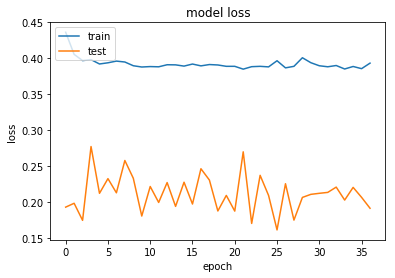

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()